In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo =False)

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Using the inspector to print the column names
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Using the inspector to print the column names
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [10]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
# reflect the tables

['measurement', 'station']

In [12]:
# We can view all of the classes that automap found
Measurement = Base.classes.measurement

In [13]:
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [15]:
latestdate = session.query(func.max(Measurement.date)).scalar()
latestdate

'2017-08-23'

In [16]:
# Calculate the date 1 year ago from the last data point in the database
last12months= dt.datetime.strptime(latestdate, '%Y-%m-%d') - dt.timedelta(days=365)
last12months = last12months.strftime('%Y-%m-%d')
last12months

'2016-08-23'

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= last12months).all()


In [18]:
print(precipitation[0])

('2016-08-23', 0.0)


In [19]:

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_data = pd.DataFrame(precipitation, columns = ['Date' , 'Precipitation'])
prec_data.set_index('Date', inplace=True)
# Sort the dataframe by date
prec_data.sort_values('Date').head(10)



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [20]:
prec_data_ave = prec_data.groupby('Date').mean()

In [21]:
prec_data_ave.head()

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


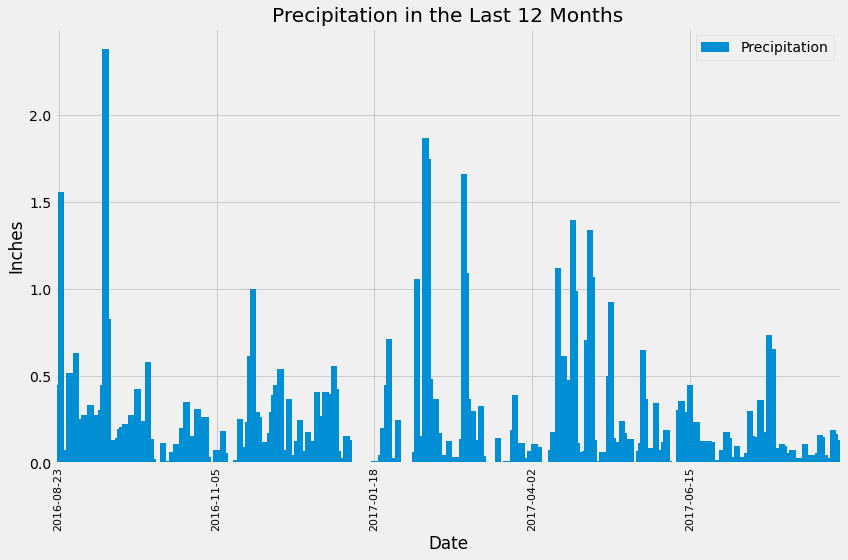

<Figure size 432x288 with 0 Axes>

In [22]:
ax = prec_data_ave.plot (kind = 'bar', width = 3, figsize=(12,8))
plt.locator_params(axis='x', nbins=5)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='x', labelsize=16)
date_label = [value for value in prec_data_ave.index]
ax.set_xticklabels(labels = date_label, rotation = 'vertical', fontsize=11)
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title('Precipitation in the Last 12 Months')
plt.tight_layout()
plt.show()
plt.savefig('Images/precipitation.png')

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.id).count()
total_stations


9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sta =[Station.station, func.count(Station.name)]
total_stationname = session.query(*sta).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()
total_stationname

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
station_query = session.query(*sel).\
    filter(Measurement.station == sta[0]).all()
station_query

[(53.0, 87.0, 73.09795396419437)]

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()

high_temp

('USC00519281', 2772)

In [28]:
station_temp = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= last12months).\
    filter(Measurement.station == high_temp[0]).all()
station_temp

[('2016-08-23', 'USC00519281', 77.0),
 ('2016-08-24', 'USC00519281', 77.0),
 ('2016-08-25', 'USC00519281', 80.0),
 ('2016-08-26', 'USC00519281', 80.0),
 ('2016-08-27', 'USC00519281', 75.0),
 ('2016-08-28', 'USC00519281', 73.0),
 ('2016-08-29', 'USC00519281', 78.0),
 ('2016-08-30', 'USC00519281', 77.0),
 ('2016-08-31', 'USC00519281', 78.0),
 ('2016-09-01', 'USC00519281', 80.0),
 ('2016-09-02', 'USC00519281', 80.0),
 ('2016-09-03', 'USC00519281', 78.0),
 ('2016-09-04', 'USC00519281', 78.0),
 ('2016-09-05', 'USC00519281', 78.0),
 ('2016-09-06', 'USC00519281', 73.0),
 ('2016-09-07', 'USC00519281', 74.0),
 ('2016-09-08', 'USC00519281', 80.0),
 ('2016-09-09', 'USC00519281', 79.0),
 ('2016-09-10', 'USC00519281', 77.0),
 ('2016-09-11', 'USC00519281', 80.0),
 ('2016-09-12', 'USC00519281', 76.0),
 ('2016-09-13', 'USC00519281', 79.0),
 ('2016-09-14', 'USC00519281', 75.0),
 ('2016-09-15', 'USC00519281', 79.0),
 ('2016-09-16', 'USC00519281', 78.0),
 ('2016-09-17', 'USC00519281', 79.0),
 ('2016-09-1

In [29]:
station_temp_df = pd.DataFrame(station_temp, columns= ['Date', 'Station' , 'Temp Observation'])
station_temp_df.head()

,Date,Station,Temp Observation
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


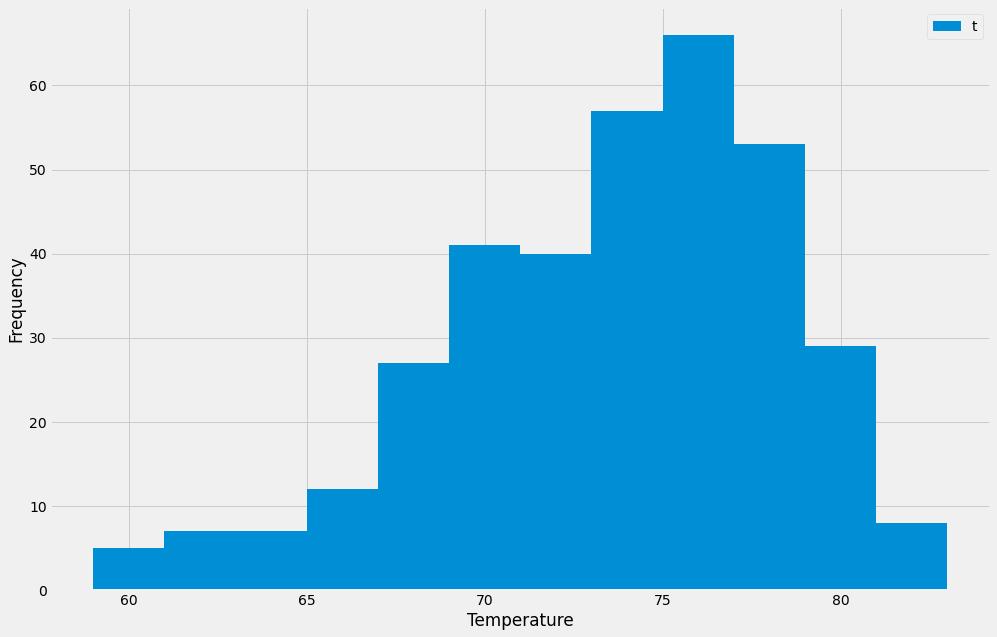

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(15,10))
plt.hist(np.ravel(station_temp_df['Temp Observation']), bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('tobs', loc = 'best')
plt.show()
plt.tight_layout()
plt.savefig('Images/station_histogram.png')

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_yr_data = calc_temps('2016-08-23', '2017-08-23')
prev_yr_data


[(58.0, 74.59058295964125, 87.0)]

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = prev_yr_data[0][2]
tmin = prev_yr_data[0][0]
tavg = prev_yr_data[0][1]
peak_to_peak = tmax - tmin


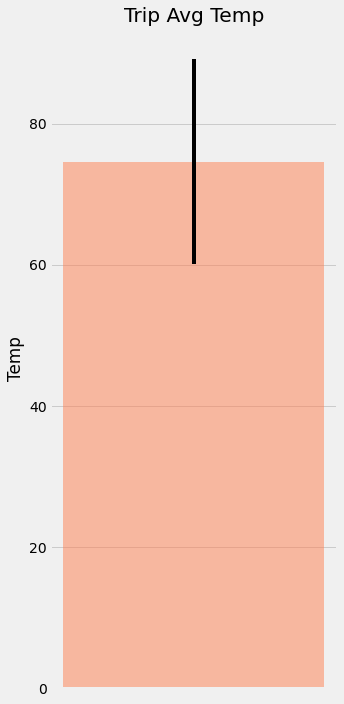

In [34]:
fig, ax1 = plt.subplots(figsize = (5,10))
ax1.bar(x=1, height = tavg, yerr = peak_to_peak/2, alpha=0.5, width = 0.4, color = 'coral')
ax1.set_xticks([0])
plt.title('Trip Avg Temp')
plt.ylabel('Temp')
plt.savefig('Images/trip_avg_temp.png')
plt.tight_layout()
plt.show()

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date.between(last12months,latestdate)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp)).all()

rainfall


[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 4.59),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 16.089999999999986),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 33.239999999999995),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 38.01),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 48.510000000000026),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 70.03000000000003),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 147.81000000000006)]

In [36]:
session.close()